In [23]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
import graphviz
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score

In [2]:
df_original = pd.read_csv("sales_train_final.csv")
df_original

,Unnamed: 0,date_block_num_x,item_id,shop_id,month_year_name_sort,item_cnt_month,item_cnt_last_month,item_cnt_last_year,month_year_name,month_of_year,quarter,year_half,year,red_day_not_sun
0,0,0,19,0,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
1,1,0,19,1,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
2,2,0,19,2,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
3,3,0,19,3,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
4,4,0,19,4,201301,0.0,0.0,0.0,January 2013,1,1,1,2013,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913845,10913845,33,22167,55,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913846,10913846,33,22167,56,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913847,10913847,33,22167,57,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31
10913848,10913848,33,22167,58,201510,0.0,0.0,0.0,October 2015,10,4,2,2015,31


In [3]:
df_draft = df_original.copy()

In [4]:
mm_scaler = MinMaxScaler()
df_draft["item_cnt_last_month"] = mm_scaler.fit_transform(df_draft[["item_cnt_last_month"]])
df_draft["item_cnt_last_year"] = mm_scaler.fit_transform(df_draft[["item_cnt_last_year"]])
df_draft["red_day_not_sun"] = mm_scaler.fit_transform(df_draft[["red_day_not_sun"]])

In [5]:
unique_values = df_draft['date_block_num_x'].unique()[-2:]

test = df_draft[df_draft['date_block_num_x'].isin(unique_values)]

train = df_draft[~df_draft['date_block_num_x'].isin(unique_values)]

In [8]:
features = [
    "item_cnt_last_month",
    "item_cnt_last_year",
    "month_of_year",
    "red_day_not_sun"
]
y_test = test["item_cnt_month"]
X_test = test[features]

y_train = train.loc[train["date_block_num_x"] >= 12, "item_cnt_month"]
X_train = train.loc[train["date_block_num_x"] >= 12, features]


In [9]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

LinearRegression()

In [10]:
model_xgb = XGBRegressor(max_depth = 2, early_stopping_rounds= 2)
model_xgb.fit(X=X_train, y=y_train, eval_set = [(X_test, y_test)])

[0]	validation_0-rmse:6.04284
[1]	validation_0-rmse:6.00642
[2]	validation_0-rmse:5.99497
[3]	validation_0-rmse:5.97918
[4]	validation_0-rmse:5.97918
[5]	validation_0-rmse:5.97396
[6]	validation_0-rmse:5.97396
[7]	validation_0-rmse:5.97396
[8]	validation_0-rmse:5.96925
[9]	validation_0-rmse:5.96925
[10]	validation_0-rmse:5.96406
[11]	validation_0-rmse:5.96406
[12]	validation_0-rmse:5.96406


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
y_test_pred_lr = model.predict(X_test)


In [12]:
y_test_pred_xgb = model_xgb.predict(X_test)

In [13]:
y_pred_test_naive = X_test["item_cnt_last_month"]

In [14]:
r2_lr = model.score(X=X_test, y=y_test)
rmse_lr = np.sqrt(mean_squared_error(y_true=np.clip(y_test, 0, 20), y_pred=np.clip(y_test_pred_lr, 0, 20)))
r2_xgb = model_xgb.score(X=X_test, y=y_test)
rmse_xgb = np.sqrt(mean_squared_error(y_true=np.clip(y_test, 0, 20), y_pred=np.clip(y_test_pred_xgb, 0, 20)))
rmse_naive = np.sqrt(mean_squared_error(y_true=np.clip(y_test, 0, 20), y_pred=np.clip(y_pred_test_naive, 0, 20)))


print(f"""
R2 LR: {r2_lr}      
RMSE LR: {rmse_lr}
""")
print(f"""
R2 XGB: {r2_xgb}
RMSE XGB: {rmse_xgb}
""")
print(f"""
R2 Naive: {r2_score(y_true=y_test, y_pred=y_pred_test_naive)}
RMSE Naive {rmse_naive}
""")


R2 LR: 0.16174781184151177      
RMSE LR: 1.0326832781161572


R2 XGB: 0.04707327226512881
RMSE XGB: 1.0088555191411392


R2 Naive: -0.0021229575728256567
RMSE Naive 1.1699632574251642



## One feature: "item_cnt_last_month"
R2 LR: 0.16984768906967662      
RMSE LR: 1.0120525315903945

R2 XGB: 0.035458778428383186
RMSE XGB: 1.042069817538063

R2 Naive: -0.0023819249886074534
RMSE Naive 1.1705952068119967



In [21]:
model_tree = DecisionTreeRegressor(max_depth=3)
model_tree= model_tree.fit(X=X_train, y=y_train)

[Text(0.5, 0.875, 'x[0] <= 0.236\nsquared_error = 11.212\nsamples = 5968267\nvalue = 0.325'),
 Text(0.25, 0.625, 'x[0] <= 0.065\nsquared_error = 6.304\nsamples = 5968125\nvalue = 0.316'),
 Text(0.125, 0.375, 'x[0] <= 0.021\nsquared_error = 4.531\nsamples = 5967115\nvalue = 0.304'),
 Text(0.0625, 0.125, 'squared_error = 3.131\nsamples = 5928047\nvalue = 0.255'),
 Text(0.1875, 0.125, 'squared_error = 162.659\nsamples = 39068\nvalue = 7.651'),
 Text(0.375, 0.375, 'x[1] <= 0.003\nsquared_error = 4912.21\nsamples = 1010\nvalue = 74.937'),
 Text(0.3125, 0.125, 'squared_error = 3274.058\nsamples = 573\nvalue = 50.677'),
 Text(0.4375, 0.125, 'squared_error = 5276.661\nsamples = 437\nvalue = 106.746'),
 Text(0.75, 0.625, 'x[1] <= 0.42\nsquared_error = 65501.25\nsamples = 142\nvalue = 375.514'),
 Text(0.625, 0.375, 'x[0] <= 0.49\nsquared_error = 54893.693\nsamples = 102\nvalue = 302.794'),
 Text(0.5625, 0.125, 'squared_error = 36636.261\nsamples = 78\nvalue = 262.244'),
 Text(0.6875, 0.125, 'squ

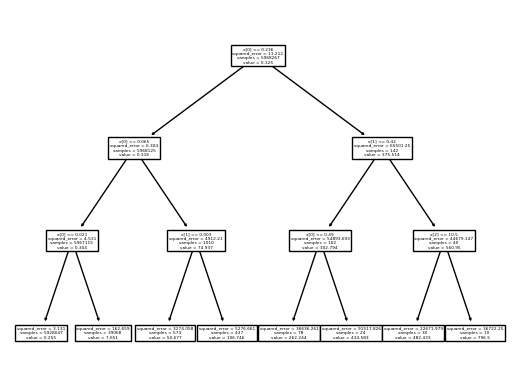

In [22]:
tree.plot_tree(model_tree)

In [25]:
dot_data = export_graphviz(model_tree, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH